In [1]:
%matplotlib notebook
# %matplotlib nbagg
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import timeit

<IPython.core.display.Javascript object>


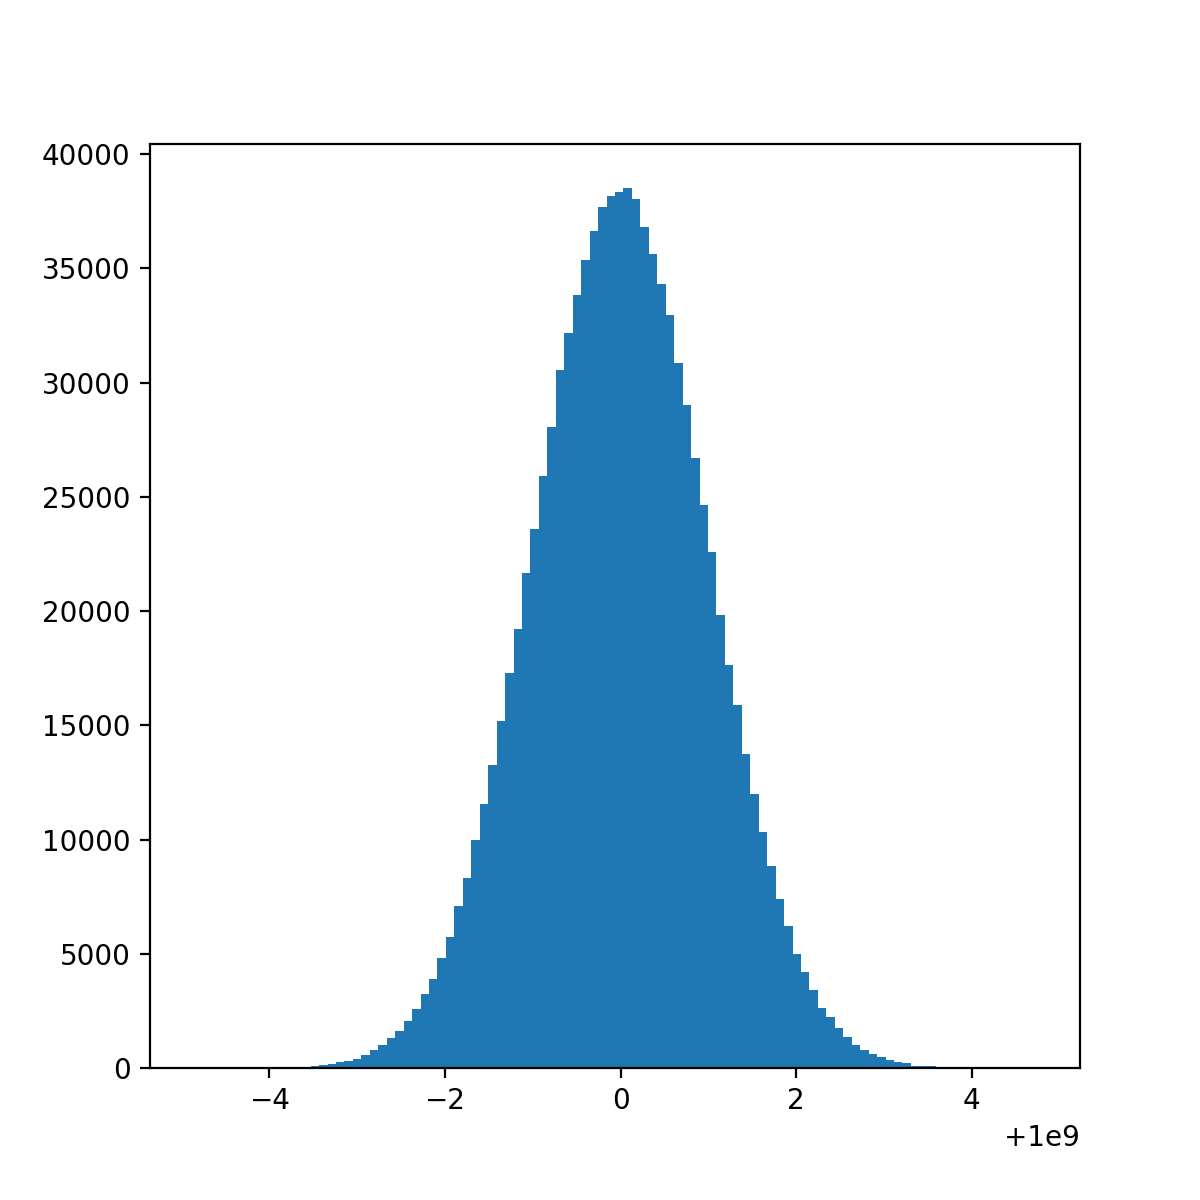

In [8]:
# x = np.random.randn(1000000) + 1e9
# 32 is too small
# x = np.asarray(np.random.randn(int(1e6)), dtype=np.float32) + 1e9
# 64
# x = np.asarray(np.random.randn(int(1e6)), dtype=np.float64) + 1e9
# 128 (obviously uses some trickery)
x = np.asarray(np.random.randn(int(1e6)), dtype=np.float128) + 1e9

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.hist(x, bins=100)
plt.show()

numpy
0.99889970715510734145
post
21.16814916814916815
naive
8.978440978440979
welford
0.9989017060586929


<IPython.core.display.Javascript object>


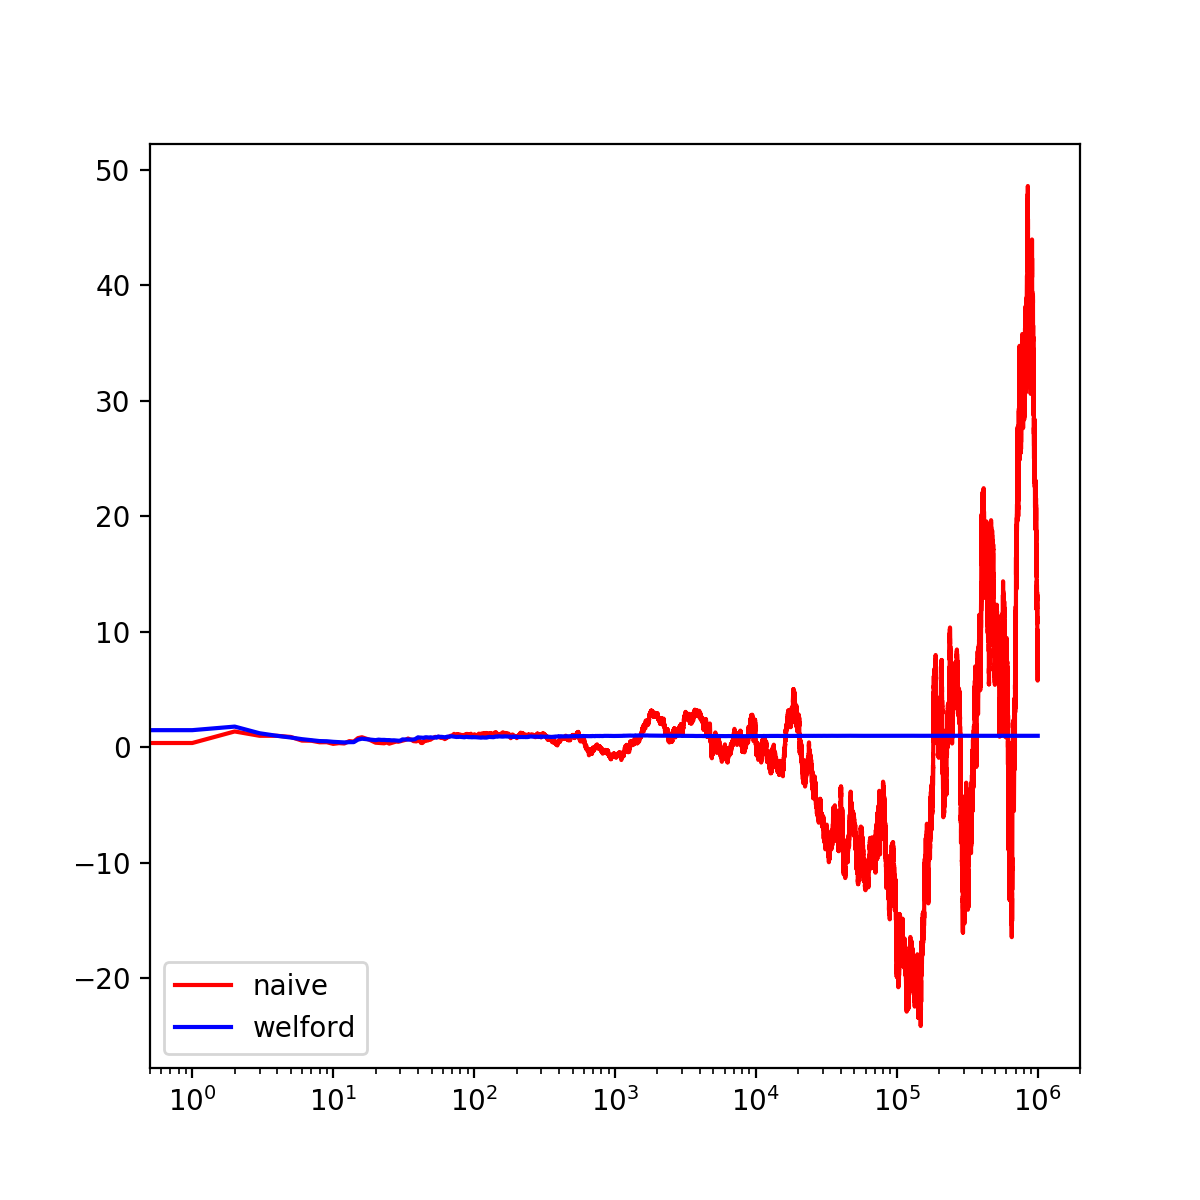

<IPython.core.display.Javascript object>


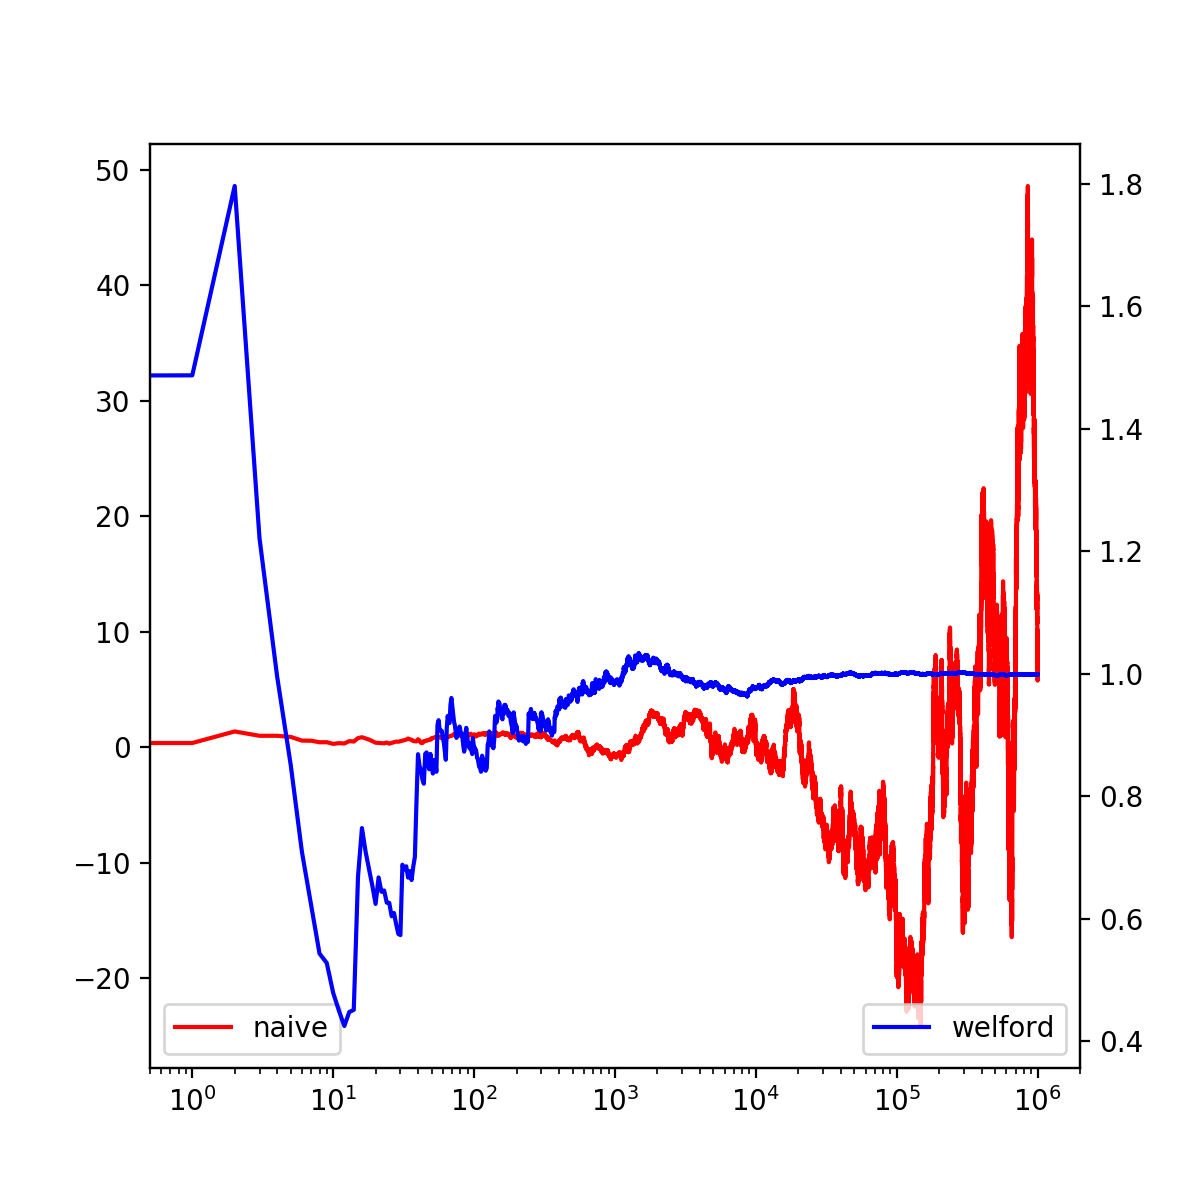

In [9]:
# std = sqrt(mean(abs(x - x.mean())**2))
print("numpy")
print(np.std(x)**2)

n = x.shape[0]

SqrSum = np.sum(np.power(x, 2))
SumSqr = np.power(np.sum(x), 2)
myStd = (SqrSum - (SumSqr/n))/(n-1)
print("post")
print(myStd)
naiveStd = fastNaive(x)
print("naive")
print(naiveStd[-1])
welfordStd = fastWelford(x)
print("welford")
print(welfordStd[-1])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(x.shape[0]), naiveStd, color="red", label="naive")
ax.plot(np.arange(x.shape[0]), welfordStd, color="blue", label="welford")
ax.set_xscale("log", nonposx='clip')
ax.legend(loc='lower left')
# ax1.legend(loc='lower right')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(x.shape[0]), naiveStd, color="red", label="naive")
ax1 = ax.twinx()
ax1.plot(np.arange(x.shape[0]), welfordStd, color="blue", label="welford")
ax.set_xscale("log", nonposx='clip')
ax.legend(loc='lower left')
ax1.legend(loc='lower right')
plt.show()

In [5]:
def naive(x):
    SqrSum = 0
    SumSqr = 0
    s = np.zeros(shape=x.shape)
    for i in range(x.shape[0]):
        k = i + 1
        SqrSum += x[i] * x[i]
        SumSqr += x[i]
        s[i] = (SqrSum - ((SumSqr*SumSqr)/(k)))/(k-1)
    return s

@jit
def fastNaive(x):
    SqrSum = 0
    SumSqr = 0
    s = np.zeros(shape=x.shape)
    # do one iteration to avoid zero issue
    i = 0
    k = i + 1
    SqrSum += x[i] * x[i]
    SumSqr += x[i]
    s[i] = 1
    for i in range(1, x.shape[0]):
        k = i + 1
        SqrSum += x[i] * x[i]
        SumSqr += x[i]
        s[i] = (SqrSum - ((SumSqr*SumSqr)/(k)))/(k-1)
    return s

def welford(x):
    M = 0
    S = 1
    s = np.zeros(shape=x.shape)
    for i in range(x.shape[0]):
        k = i + 1
        nM = M + (x[i] - M)/k
        nS = S + (x[i] - M)*(x[i]-nM)
        s[i] = nS/(k-1)
        M = nM
        S = nS
    return s

@jit
def fastWelford(x):
    M = 0
    S = 1
    s = np.zeros(shape=x.shape)
    # do one iteration to avoid the zero issue
    i = 0
    k = i + 1
    nM = M + (x[i] - M)/k
    nS = S + (x[i] - M)*(x[i] - nM)
    s[i] = 1
    M = nM
    S = nS
    for i in range(1, x.shape[0]):
        k = i + 1
        nM = M + (x[i] - M)/k
        nS = S + (x[i] - M)*(x[i] - nM)
        s[i] = nS/(k-1)
        M = nM
        S = nS
    return s